# Main Data Analysis

## Processing Steps
- Fast Fourier transformation for each voxel masked by the previously obtained gray matter mask (see Preprocessing_fps.ipynb)
- Convert amplitude of the frequency of the face bursts into a z-score
    - Interpreted as SNR
    - Formula: $SNR = \frac{(A_S - \mu_N)}{\sigma_N}$
    - $A_S$: Amplitude of the face stimulation frequency
    - $\mu_N$: Mean of 40 neighboring frequency bins (binwidth=0.0025Hz, 20 on each side)
    - $\sigma_N$: Standard deviation of the amplitude of 40 neighboring frequencies
- Use phase values to determine the onset of activation/deactivation
    - phase value of 0: Maximum BOLD response at the time the pictures were presented
    - positive phase value: Increasing BOLD response after the onset of faces
    - negative phase value: Decreasing BOLD response after the onset of faces
- Plot histogram of phase values of voxels with z-score>3 and positive phase value
    - 

## Illustration of the fast Fourier transform
First, we import needed packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

For illustration purposes we make an array of values following a sine function:

In [2]:
sine_array = np.sin(np.arange(0,20,0.1))

Next, we do a fast Fourier Transform on the `sine_array` using the `fft` function in `numpy`. The function has another array as output that we call `fourier`.

The `fourier` array contains the output of the transform with a real and an imaginary part.

Note in the plot that the array is mirrored.

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


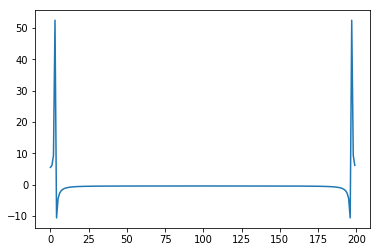

In [3]:
fourier = np.fft.fft(sine_array)
plt.plot(fourier)

As the output of the `fft` is mirrored, we only need the first half. For this reason we compute `N`, a variable that determines half the length of the `fourier` array.

In [4]:
N = int(len(fourier)/2+1)

To obtain the amplitude values, we have to compute the absolute values of the first half of the `fourier` array.

101


93.21311750238416

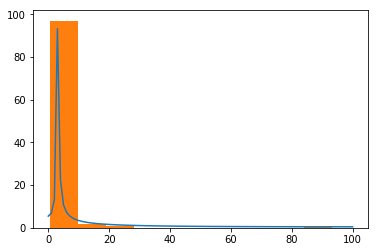

In [5]:
amplitude = (abs(fourier[:N]))
plt.plot(amplitude)
print(len(amplitude))
plt.show
plt.hist(amplitude)
max(amplitude)

To determine the phase of the signal, we have to determine the angle of the first half of the `fourier` array.

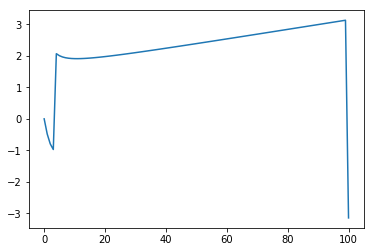

In [6]:
phase = np.angle(fourier[:N])
plt.plot(phase)

`amplitude` and `phase` should have the same length.

In [7]:
print(len(amplitude))
print(len(phase))
len(amplitude)==len(phase)

101
101


True

`fft` automatically gives as many data points as the array that we fed into the function. To find out which data point refers to which frequency, we have to use `fftfreq`. This function takes as arguments the window length, so for how long we measured (how many data points we obtained), and the sample spacing `d`, which will later be the TR of the scanner. For illustration purposes, we will change it `d = 0.1`, as this was the sample spacing in our illustration data.

In [8]:
np.fft.fftfreq(sine_array.size, d = 0.1)

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
        3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
        3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
        4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
        4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
        4.95, -5.  , -4.95, -4.9 , -4.85, -4.8 , -4.75, -4.7 , -4.65,
       -4.6 , -4.55, -4.5 , -4.45, -4.4 , -4.35, -4.3 , -4.25, -4.2 ,
       -4.15, -4.1 , -4.05, -4.  , -3.95, -3.9 , -3.85, -3.8 , -3.75,
       -3.7 , -3.65,

## Data Analysis

Now that we know how the fast Fourier transform works in Python, we can start with our data analysis.

First, we need to import required packages.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.input_data import NiftiMasker
from nipype import Node, MapNode, Workflow, SelectFiles, Function

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/duecredit/utils.py:32: PendingDeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  and platform.linux_distribution()[0] == 'debian' \


We are going to set up the data analysis as a nipype workflow, similar to how we did our preprocessing.

In [10]:
analysis = Workflow(name='work_analysis',
                    base_dir='/home/neuro/fps/fps_bids/derivatives/')

We again have to build a template so we can access the needed files and iterate through the participants. We also set up the node `sf`, that we can use to access the files we need.

In [11]:
templates = {'detr':
             'derivatives/work_preprocessing/'
             '_subject_id_{subject_id}/detrend/detrend.nii.gz',
            }
sf = Node(SelectFiles(templates,
                      base_directory='/home/neuro/fps/fps_bids/',
                      sort_filelist=True),
          name='selectfiles')
sf.inputs.task_id='fps'

In [12]:
subject_list = ['01','02']
sf.iterables = [('subject_id', subject_list)]

For the fast Fourier transform we have to build our own custom function.

The `masker` transforms our preprocessed NIfTI file into a two dimensional array that we call `image_array`. This array has the dimensions `(270, 44592)`, which means that there are 270 images (each one functional image in the time series) with 44592 voxels each.

We need to compute the fft for every voxel over time. For this, we transpose the array, so that each list in our new array `image_array_t` now contains voxel intensity over time for one voxel each (before, each list in the array contained the intensity of *every* voxel for *one point in time*).

Before we compute the fft, we first convert the intensity values to percentage of BOLD signal change by dividing all values by the mean intensity for that voxel and store these values in the array `image_array_perc`.

Next, we do the fast Fourier transform as illustrated above, for every voxel over time. We now use the `fftfreq` function to determine on what position our stimulation frequency lies in the `fourier` array. Or, to put it differently, we want to find out the index of the amplitude of the stimulation frequency.

Now we compute the mean and the standard deviation of the 40 neighboring bins. We use the formula from above to compute the SNR/z-score: $SNR = \frac{(A_S - \mu_N)}{\sigma_N}$

An SNR map with z-scores above 3 is then computed.

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


[1.06467232 0.60093739 0.02550244 ... 0.         0.         0.        ]


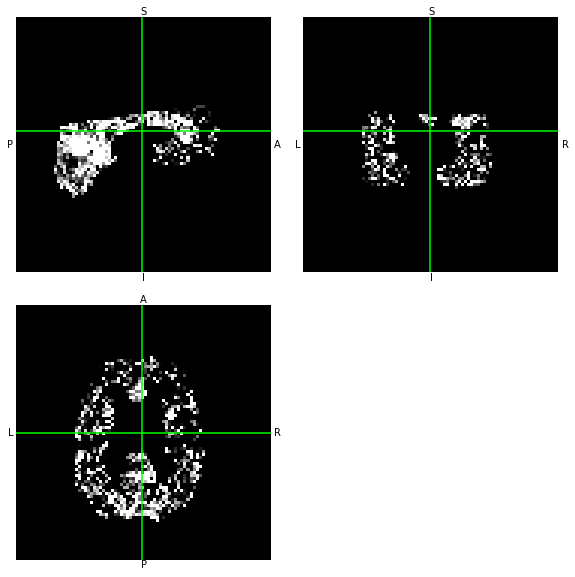

In [14]:
def fft_convert(image, stim_freq):
    from nilearn.input_data import NiftiMasker #to import the masked NIfTI file as an array
    import numpy as np
    import scipy
    import nibabel as nib
    masker = NiftiMasker(standardize=True)
    image_array = masker.fit_transform(image) #import the NIfTI
    image_array_t = image_array.T #transpose the array
    mean_intensity = image_array_t.mean(axis=1) #determine the mean intensity of every voxel
    #divide the intensity values by the mean intensity in that voxel:
    image_array_perc = image_array_t / mean_intensity[:,None] 
    
    SNR_map = np.ones(44592)
    
    for i in range(len(image_array_perc)):
        fourier = np.fft.fft(image_array_perc[i]) #the Fourier transform
        N = int(len(fourier)/2+1) #determine half the length of the array
        amplitude = (abs(fourier[:N])) #get the amplitude values
        phase = np.angle(fourier[:N]) #get the phase values
        freq_mir = np.fft.fftfreq(n = 270, d=1.03) #the frequency values, also mirrored
        freq = freq_mir[:N] #the frequency values without the mirrored part
        frate = 1/1.03
        freq_in_hertz = abs(freq * frate)
        #print(freq_in_hertz)
        
        #determine the index of the stimulation frequency:
        index = min(range(len(freq_in_hertz)), key=lambda i: abs(freq_in_hertz[i]-stim_freq))
        
        #use that index to get the 40 neighboring bins:
        lower1 = index-20
        lower2 = index+1
        upper = index+21
        mu_values = amplitude[lower1:index]
        mu_values = np.append(mu_values, amplitude[lower2:upper])
        mu = np.mean(mu_values) #calculate mu
        sigma = np.std(mu_values) #calculate sigma
        As = amplitude[index] #calculate As
        SNR = (As-mu)/sigma #calculate the signal to noise ratio
        phase_value = phase[index] #phase value at stimulation frequency
        
        #compute SNR map for values with z>3.0:
        if SNR > 0.0:
            SNR_map[i]*=SNR
        else:
            SNR_map[i]*=0.
            
    out_file = masker.inverse_transform(SNR_map)
    nib.save(out_file,'SNR_test_tresh_3.nii') #!!!change path to /fps_bids/derivatives/work_data_analysis/
    %matplotlib inline
    out_file.orthoview()
    print(SNR_map)
    #print(mu_values)
    #print(mu)
    #print(sigma)
    #print(SNR)
    #print(image_array_t.shape)
    
    #hist = np.histogram(amplitude, bins = 41, range=(0.061, 0.161))
    #plt.plot(amplitude)
    #plt.show
    #plt.hist(amplitude, bins = 41, range=(0.061, 0.161))
    #plt.show
    #print(image_array)
    #out_file = masker.inverse_transform()
    return(out_file)

fft_convert('/home/neuro/fps/fps_bids/derivatives/work_preprocessing/_subject_id_01/detrend/detrend.nii.gz',0.111)

In [ ]:
import scipy.stats as st
1-st.norm.cdf(3.)

In [ ]:
A = np.array([1.,2.,3.,4.,5.,6.])

print(A[0:2],A[4:5])
np.mean(A[0:2],A[4:5])
print(np.mean(A[0]))
print(type(A))

In [ ]:
270/1.03

In [ ]:
270*1.5